# This tutorial relies on DEAP

<div style="display: flex; align-items: center;">
  <div style="flex: 0 0 auto; margin-right: 20px;">
    <img src="https://deap.readthedocs.io/en/master/_images/deap_long.png" alt="Logo" width="600">
  </div>
</div>

* Evolutionary computation in python.
* Toolbox, not a collection of algorithms.
* Easy to parallelize.
* Rather steep learning curve

# Multiobjective evolutionary algorithms with many tables - MEAMT
`MEAMT` is among the first MOEAs to deal with real-world large-scale complex problems with many objectives
* Brasil, Christiane Regina Soares; Delbem, Alexandre Claudio Botazzo;  Silva, Fernando Luís Barroso; *Multiobjective evolutionary algorithm with many tables for purely ab initio protein structure prediction*
Journal of Computational Chemistry, Volume 34, Issue 20, 30 July 2013, Pages 1719-1734,
doi: [10.1002/jcc.23315](https://doi.org/10.1002/jcc.23315)


* Lafetá, Thiago; Bueno, Marcos L.P.; Brasil, Christiane; Oliveira, Gina M.B.; *MEANDS: A Many-objective Evolutionary Algorithm based on Non-dominated Decomposed Sets applied to multicast routing*,
Applied Soft Computing,
Volume 62,
2018,
Pages 851-866,
ISSN 1568-4946,
doi: [10.1016/j.asoc.2017.09.017](https://doi.org/10.1016/j.asoc.2017.09.017),
sciencedirect: [pii/S1568494617305562](https://www.sciencedirect.com/science/article/pii/S1568494617305562)

##Introduction

This project employed `MEAMT` (Multiobjective Evolutionary Algorithm with many tables) for solving the `dtlz3` benchmark problem in hope to demonstrate the algorithm potential for multiobjective optimization.

The algorithm works by isolating combinations of objectives in subpopulations called tables such that each table contains the best individuals in the population for any combination, this is done so that individuals that might have relevance for optimizing a certain objective or a combination of those are not discarded due to elitism, and the algorithm can remain diverse enough to escape local minimals.

For assessement of the results the pareto front was poltted in 3d and compared to the know solution, resulting in a solution that is acurrate and also diverse.

The `hypervolume` was also registred due to the Metric being able to asses both convergence and space (diversity), yielding a single scalar capable of representing the overall quality of the population.

## Hypervolume (HV)
The **Hypervolume (HV)**, originally proposed as the *S-metric*, is one of the most widely used metrics in multi-objective optimization. Its popularity stems from the fact that it is a unary metric capable of simultaneously capturing two crucial characteristics of a solution set:

1.  **Convergence:** The proximity of the solutions to the true Pareto Front.
2.  **Diversity:** The spread and distribution of solutions within the objective space.

Mathematically, Hypervolume calculates the volume of the objective space that is "dominated" by the obtained solution set ($S$), bounded by a reference point ($r$):

$$
HV(S, r) = \text{Vol} \left( \bigcup_{x \in S} [f_1(x), r_1] \times \dots \times [f_m(x), r_m] \right)
$$

The larger the Hypervolume value, the better the quality of the solution set [1].

##DTLZ and Expected Outcome
The DTLZ3 test function is a scalable, multi-objective optimization problem introduced by Deb et al. (2002). It is specifically designed to evaluate a Multi-Objective Evolutionary Algorithm's (MOEA) ability to converge to the global Pareto-optimal front in the presence of massive multi-modality[2].

**Mathematical Definition**

The objective functions to be minimized are defined as follows:$$\begin{aligned}
\min f_1(\mathbf{x}) &= (1 + g(\mathbf{x}_M)) \cos(x_1\pi/2) \dots \cos(x_{M-1}\pi/2) \\
\min f_2(\mathbf{x}) &= (1 + g(\mathbf{x}_M)) \cos(x_1\pi/2) \dots \sin(x_{M-1}\pi/2) \\
\vdots \\
\min f_M(\mathbf{x}) &= (1 + g(\mathbf{x}_M)) \sin(x_1\pi/2) \\
\end{aligned}$$The ruggedness of the landscape is governed by the $g(\mathbf{x}_M)$ function, which uses a Rastrigin-like transformation:$$g(\mathbf{x}_M) = 100 \left[ |x_M| + \sum_{x_i \in \mathbf{x}_M} ((x_i - 0.5)^2 - \cos(20\pi(x_i - 0.5))) \right]$$

The following image denotes a perfect pareto front solution to the problem

<div style="display: flex; align-items: center;">
  <div style="flex: 0 0 auto; margin-right: 20px;">
    <img src="https://pymoo.org/_images/problems_many_dtlz_26_1.png" alt="Logo" width="500">
  </div>
</div>


##Implementation

###Install DEAP


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 2.9 MB/s eta 0:00:00


###Including methods and packages



In [ ]:
import random
from deap import creator, base, tools, benchmarks
from deap.benchmarks.tools import hypervolume
import matplotlib.pyplot as plt

###Setting config

In [ ]:
IND_SIZE = 12 # Individual size (cromossome)
NPOP = 640 # Population size
NGEN = 500 # Number of generations
NOBJ = 3 # Number of objectives
CXPB = 0.9 # Denotes crossover probability
MUTPB = 1.0 # Denotes mutation probability
NUM_TABLES = int((1 << NOBJ)) # Indicates number of tables (8 for 3 objectives)
MAX_TABLE_SIZE = int(NPOP / NUM_TABLES) # Number of individuals in each subpopulation (table)


###Setup and Toolbox
> `DEAP` allows for creation of custom classes and functions along with pre-existing to facilitate implementation, in this case while `parent selection strategy` is custom-designed, the mutation and crossover operators utilize literature gold standard methods provided by the library. This way `MEAMT` perfomance can be isolated and determined with high certainty.

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
creator.create("Individual", list, fitness=creator.FitnessMin, Parent_Table=None)
creator.create("SubPopulation", list, score=0.0) # In MEAMT the population is distributed in subpopulations at scored tables

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=NPOP)
toolbox.register("evaluate", benchmarks.dtlz3, obj=NOBJ) # Benchmark for this test
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=20.0, low=0.0, up=1.0)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=20.0, low=0.0, up=1.0, indpb=1.0/IND_SIZE)

REF_POINT_HV = [1.1] * 3  # Refpoints for Hypervolume

###Auxiliar Functions

In [ ]:
# This function is used to calculate the combined fitness of an individual with respect to his table
def calc_combined_fitness(ind, table_idx):
    fit = 0
    # Bit 0 -> Obj 2 | Bit 1 -> Obj 1 | Bit 2 -> Obj 0
    if (table_idx >> 0) & 1: fit += ind.fitness.values[2]
    if (table_idx >> 1) & 1: fit += ind.fitness.values[1]
    if (table_idx >> 2) & 1: fit += ind.fitness.values[0]
    return fit

# This function inserts inicial population in the tables
def gen_inicial_tables(pop_ini, num_tables, table_size):
    tables = dict()
    # Tabel 0: ND (Non Dominated)
    fronteira = tools.sortNondominated(pop_ini, len(pop_ini), first_front_only=True)[0]
    tables[0] = creator.SubPopulation(fronteira[:table_size]) # Corta se for maior
    tables[0].score = 0.0

    # Tabel 1 to 7
    for i in range(1, num_tables):
        pop_ordenada = sorted(pop_ini, key=lambda ind: calc_combined_fitness(ind, i))
        tables[i] = creator.SubPopulation(pop_ordenada[:table_size])
        tables[i].score = 0.0
    return tables

`MEAMT` selects the parents to reproduction by a tournment of 2, the tournment occours between tables with respect to their `score`, a selected table
choses and individual of its subpopulation randomly and if such an individual generates succeful offspring the `score` of the table is increased by one.

In [ ]:
def select_parents(tables, num_tables):
    selected = []
    for _ in range(2):
         random1 = random.randint(0, num_tables - 1)
         random2 = random.randint(0, num_tables - 1)

         if len(tables[random1]) == 0: winner = random2
         elif len(tables[random2]) == 0: winner = random1
         elif tables[random1].score >= tables[random2].score:
             winner = random1
         else:
             winner = random2

         ind = random.choice(tables[winner])
         ind.Parent_Table = winner
         selected.append(ind)
    return selected

### Selection run-down
To insert a new individual in a table we first verify if the new individual combained fitness is better than the worst of said table. This is done in the `Non Denominated` subpop by appending the new individual and selecting all individuals again using `NSGA-II`, if the individual survives, then the score of its parent is increased.
In other tables linear search is used to find the worst individual present in the subpopulation, then its verified if its wheighted fitness is worse than the fitness from the new one, if it is, the worst individual is replaced in the subpop and, as previous, table score is increased.

In [ ]:
def insert_in_tables(tables, num_tables, off, max_table_size):
    # 1. Insert on table ND (0)
    tabela_nd = tables[0]
    tabela_nd.append(off)
    # NSGA2 select
    nova_selecao = tools.selNSGA2(tabela_nd, max_table_size)
    tabela_nd[:] = nova_selecao

    # Se off is in the table -> increase score
    if any(ind is off for ind in tabela_nd):
        if off.Parent_Table is not None:
            tables[off.Parent_Table].score += 1

    # Try to insert in other tables
    for i in range(1, num_tables):
        fit_off = calc_combined_fitness(off, i)

        worse_val = -1.0
        worse_idx = -1

        for idx, ind in enumerate(tables[i]):
            fit_ind = calc_combined_fitness(ind, i)
            if fit_ind > worse_val:
                worse_val = fit_ind
                worse_idx = idx

        # Minimization: If new is less than the worst, replaces it
        if fit_off < worse_val:
            tables[i][worse_idx] = off
            if off.Parent_Table is not None:
                tables[off.Parent_Table].score += 1

In the "run" function the algoritm is executed "NGEN" times. For each offspring, crossover and mutation operators are applied, at each gen the `tables scores` are reset, this way is reduced.

In [ ]:
def run(tables, num_tables, max_table_size, ngen, toolbox, cxpb, mutpb):
    logbook = tools.Logbook()
    logbook.header = "gen", "hypervolume"
    for gen in range(1, ngen + 1):
        # Reset score
        for t in tables.values():     t.score = 0.0

        for _ in range((max_table_size * num_tables) // 2):
             parents = select_parents(tables, num_tables)

             off1 = toolbox.clone(parents[0])
             off2 = toolbox.clone(parents[1])

             off1.Parent_Table = parents[0].Parent_Table
             off2.Parent_Table = parents[1].Parent_Table

             # Crossover
             if random.random() < cxpb:
                toolbox.mate(off1, off2)
                del off1.fitness.values
                del off2.fitness.values

             # Mutation
             if random.random() < mutpb:
                toolbox.mutate(off1)
                del off1.fitness.values
             if random.random() < mutpb:
                toolbox.mutate(off2)
                del off2.fitness.values

             # Assessment
             if not off1.fitness.valid:
                 off1.fitness.values = toolbox.evaluate(off1)
             if not off2.fitness.valid:
                 off2.fitness.values = toolbox.evaluate(off2)

             # Insertion
             insert_in_tables(tables, num_tables, off1, max_table_size)
             insert_in_tables(tables, num_tables, off2, max_table_size)
        hv_val = hypervolume(tables[0], REF_POINT_HV)
        logbook.record(gen=gen,hypervolume=hv_val)
        print(logbook.stream)
    return logbook

Main Function

In [ ]:
if __name__ == "__main__":
    pop_ini = toolbox.population()
    for ind in pop_ini:
        ind.fitness.values = toolbox.evaluate(ind)

    tables = gen_inicial_tables(pop_ini, NUM_TABLES, MAX_TABLE_SIZE)
    logbook = run(tables, NUM_TABLES, MAX_TABLE_SIZE, NGEN, toolbox, CXPB, MUTPB)

gen	hypervolume
1  	0          
2  	0          
3  	0          
4  	0          
5  	0          
6  	0          
7  	0          
8  	0          
9  	0          
10 	0          
11 	0          
12 	0          
13 	0          
14 	0          
15 	0          
16 	0          
17 	0          
18 	0          
19 	0          
20 	0          
21 	0          
22 	0          
23 	0          
24 	0          
25 	0          
26 	0          
27 	0          
28 	0          
29 	0          
30 	0          
31 	0          
32 	0          
33 	0          
34 	0          
35 	0          
36 	0          
37 	0          
38 	0          
39 	0          
40 	0          
41 	0          
42 	0          
43 	0          
44 	0          
45 	0          
46 	0          
47 	0          
48 	0          
49 	0          
50 	0          
51 	0          
52 	0          
53 	0          
54 	0          
55 	0          
56 	0          
57 	0          
58 	0          
59 	0          
60 	0          
61 	0          
62 	0   

Graphics and Visualization

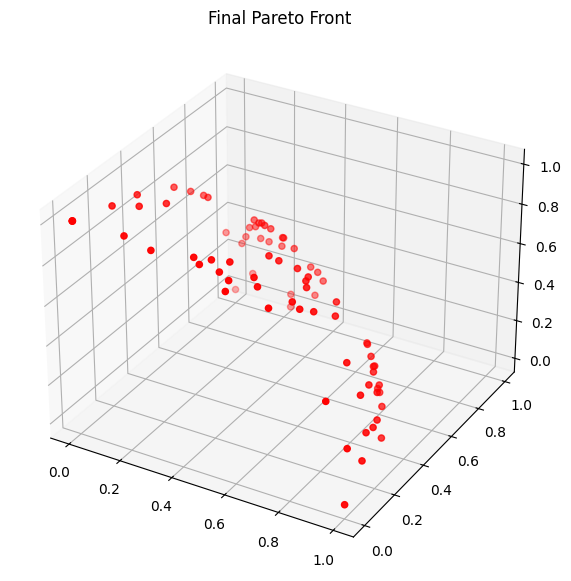

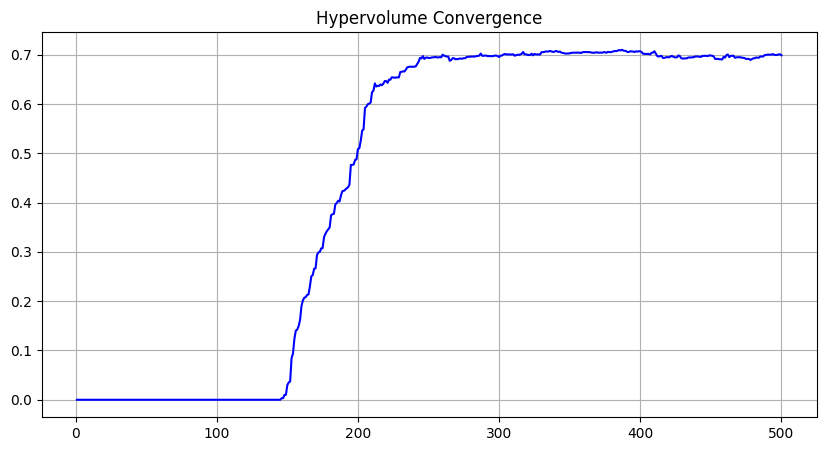

In [ ]:
    # 3D Graphic of final pareto front
    f1 = [ind.fitness.values[0] for ind in tables[0]]
    f2 = [ind.fitness.values[1] for ind in tables[0]]
    f3 = [ind.fitness.values[2] for ind in tables[0]]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(f1, f2, f3, c='r', marker='o', label='Solutions')
    ax.set_title('Final Pareto Front')
    plt.show()

    # Hypervolume Graphic
    gen = logbook.select("gen")
    fit_hv = logbook.select("hypervolume")
    plt.figure(figsize=(10, 5))
    plt.plot(gen, fit_hv, 'b-')
    plt.title("Hypervolume Convergence")
    plt.grid()
    plt.show()

## Reference
[1] E. Zitzler and L. Thiele, "Multiobjective evolutionary algorithms: a comparative case study and the strength Pareto approach," in *IEEE Transactions on Evolutionary Computation*, vol. 3, no. 4, pp. 257-271, Nov. 1999.

[2] Deb, K., Thiele, L., Laumanns, M., & Zitzler, E. (2001). Scalable Test Problems for Evolutionary Multi-Objective Optimization.